# Ex1

In [1]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# à garder si utilisation de Spyder
# %matplotlib auto
import importlib
import matplotlib

In [2]:
def toggle(mode):
    """
    Fonction pour changer de mode d'affichage des images
        inline ==> Affichage directement dans le notebook
        tk ==> Affichage dans une fenêtre à part (permet de sélectionner des points sur l'image)
    """
    if mode == "tk":
        plt.close('all')
        matplotlib.use('TkAgg', force=True)
        importlib.reload(plt)
        plt.switch_backend('TkAgg')
    elif mode == "inline":
        plt.close('all')
        matplotlib.use('Agg', force=True)
        importlib.reload(plt)
        plt.switch_backend('Agg')
        %matplotlib inline

In [3]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

patternSize = (7,6)
objp = np.zeros((patternSize[1]*patternSize[0],3), np.float32)
objp[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


################################
# Revenir ici pour question 11 #
################################
images = sorted(glob.glob('./ocv-pics/left*.jpg'))
# images = ['./ocv-pics/left01.jpg', './ocv-pics/left04.jpg', './ocv-pics/left07.jpg']

imagesok = []
listimg = []
listgray = []
listimgcorners = []
touspoints = np.array([])

# Ajout pour la methode 2 de la question 3
cumul_coins = np.zeros(cv.imread(images[0]).shape[:2], dtype=np.uint8)

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    if touspoints.size == 0:
        touspoints = np.zeros(img.shape, dtype=np.uint8)
    
    ret, corners = cv.findChessboardCorners(gray, patternSize, None)
    
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imagesok.append(fname)
        listimg.append(img.copy())
        listgray.append(gray)
        imgpoints.append(corners2)
        
        cv.drawChessboardCorners(img, patternSize, corners2, ret)

        # Ajout pour la methode 2 de la question 3
        cv.drawChessboardCorners(cumul_coins, patternSize, corners2, ret)
        
        listimgcorners.append(img)
    else:
        print("Echec de la détection des coins pour l'image {} !".format(fname))

Echec de la détection des coins pour l'image ./ocv-pics/left09.jpg !
Echec de la détection des coins pour l'image ./ocv-pics/left11.jpg !


## Q1
Pas d'erreur, l'image `calibresult.png` est bien créée et la matrice K correspond à celle sur le sujet.

## Q2

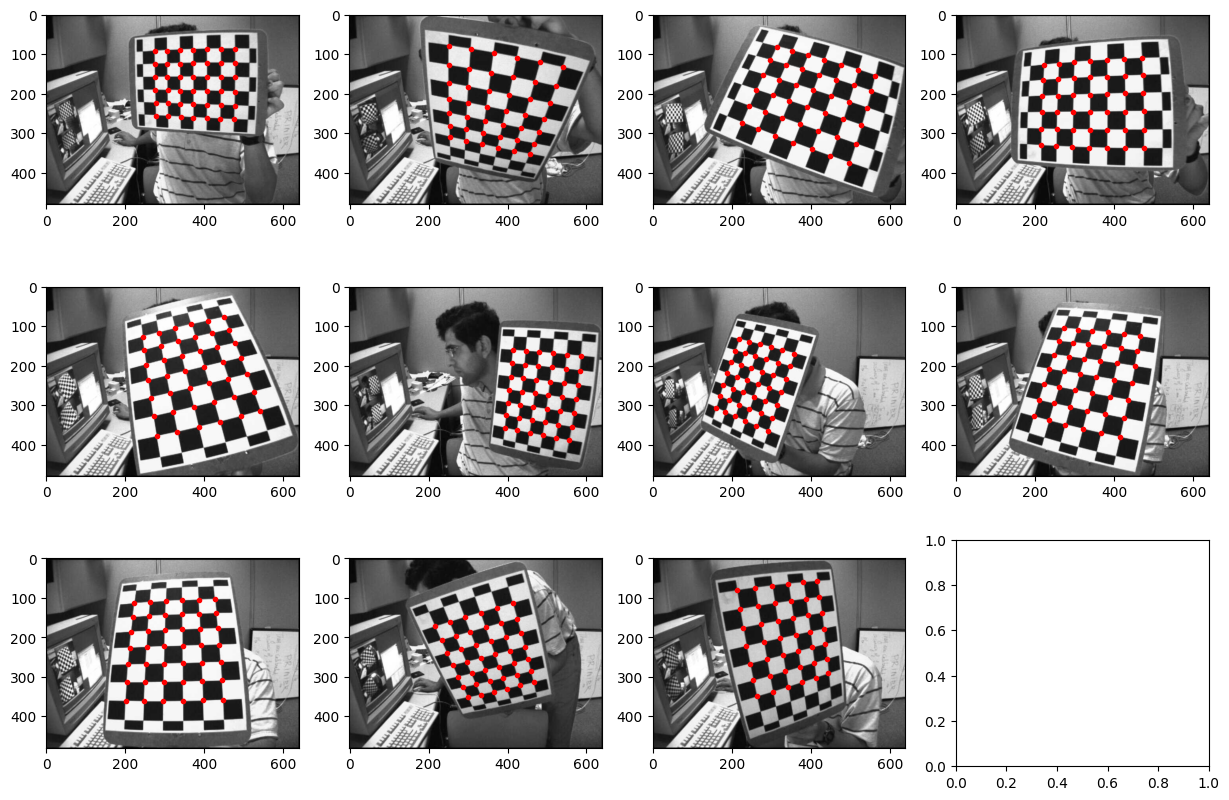

In [4]:
%matplotlib inline
from math import ceil

n_lignes = ceil(len(listimgcorners) / 4)
fig, axs = plt.subplots(n_lignes, 4, figsize=(15, 10))

for i, img, pts in zip(range(len(listimg)), listimg, imgpoints):
    row = i // 4
    col = i % 4
    if n_lignes == 1: # Quand il n'y a qu'une seule ligne (question 11)
        axs[col].imshow(img)
        axs[col].plot(pts[:, 0, 0], pts[:, 0, 1], '.r')
    else:
        axs[row, col].imshow(img)
        axs[row, col].plot(pts[:, 0, 0], pts[:, 0, 1], '.r')

plt.show()

## Q3

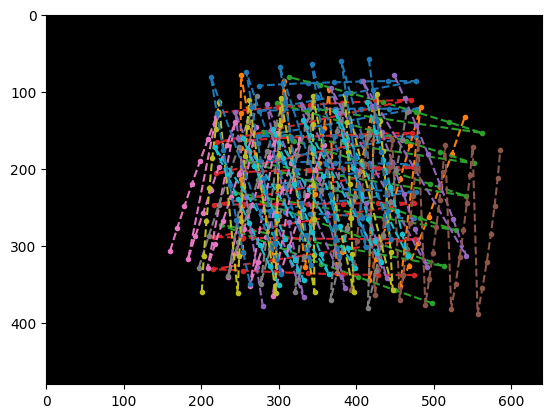

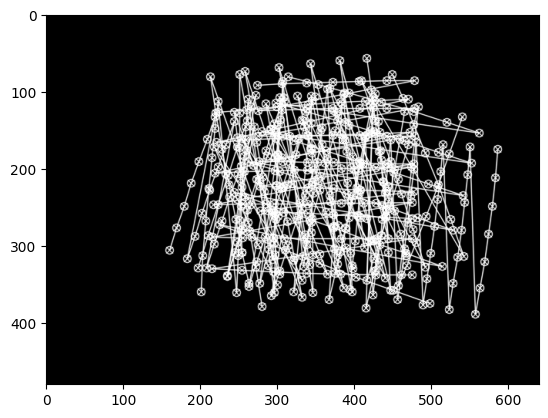

In [5]:
# Méthode 1 : cumul des coins dans un plot
for points in imgpoints:
    plt.plot(points[:,0,0], points[:,0,1], '.--')

# Mettre le fond en noir
ax = plt.gca()
ax.set_facecolor('k')

# Faire commencer les axes à 0
ax.set_xlim(0, img.shape[1])
ax.set_ylim(img.shape[0], 0)

plt.show()

# Méthode 2 : utilisation des coins cumulés sur l'image au fur et à mesure
plt.imshow(cumul_coins, cmap='gray')
plt.show()

Les photos cumulées ne recouvrent pas toutes les zones de l'image avec la mire comme suggère l'enoncé pour ce qui devrait être fait pour obtenir un bon calibrage.

In [6]:
# Calibration
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None, flags=cv.CALIB_ZERO_TANGENT_DIST)

## Q4

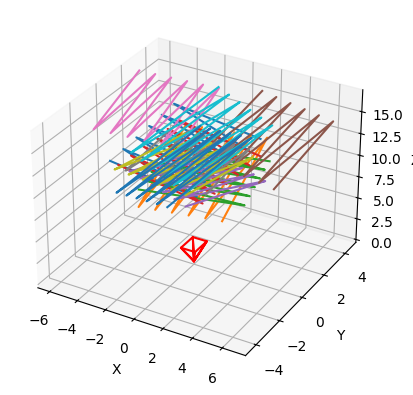

In [7]:
# Décommenter cette ligne pour basculer en mode tk et pouvoir manipuler la vue 3D
################
# toggle("tk") #
################

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for pts, rot, trans in zip(objpoints, rvecs, tvecs):
    pts = pts.T
    rmat, _ = cv.Rodrigues(rot)
    op_cam_space = (rmat @ pts) + trans
    ax.plot(op_cam_space[0, :], op_cam_space[1, :], op_cam_space[2, :])

ax.plot([0,0.5,0.5,0 , 0.5,-0.5,0 , -0.5,-0.5,0, -0.5,0.5],
    [0,-0.5,0.5,0 , 0.5,0.5,0, 0.5,-0.5,0, -0.5,-0.5],
    [0,2,2,0 , 2,2,0, 2,2,0, 2,2],
    color='r')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


In [8]:
img = cv.imread('./ocv-pics/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

dst = cv.undistort(img, mtx, dist, None, newcameramtx)

x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('calibresult.png', dst)

True

## Q5

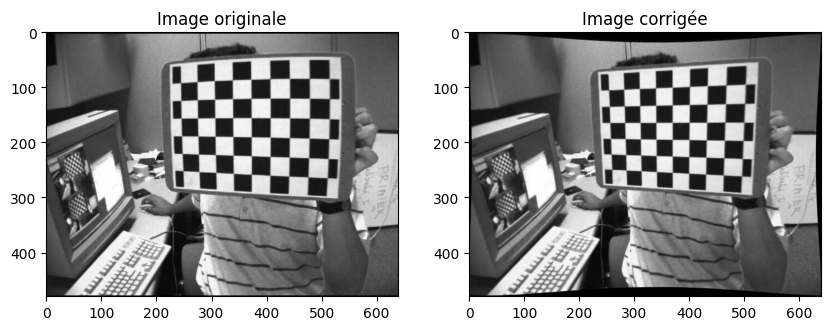

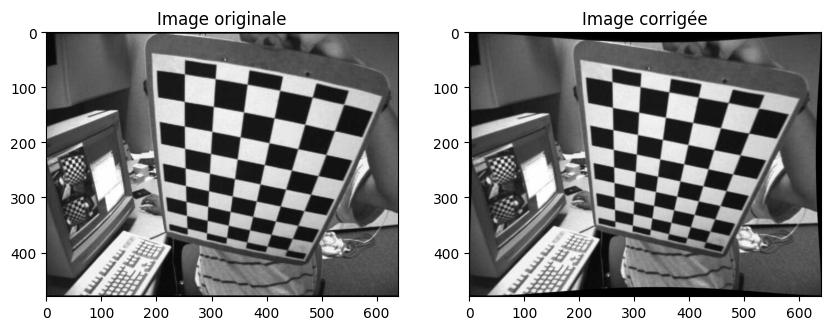

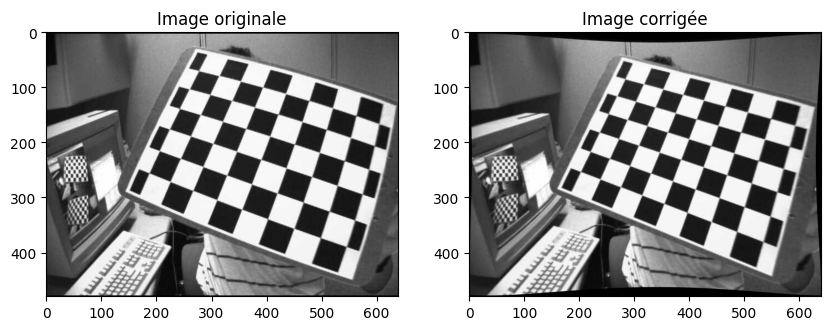

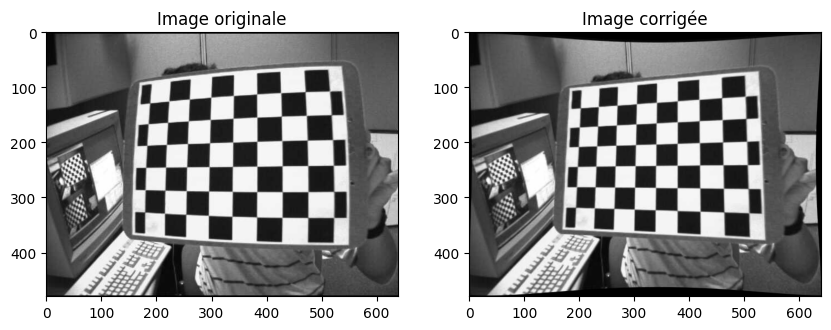

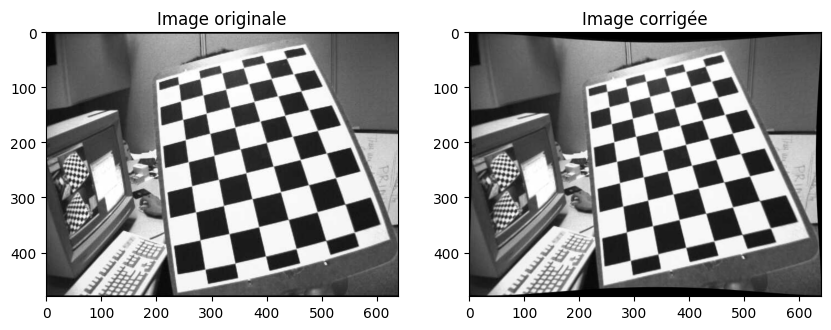

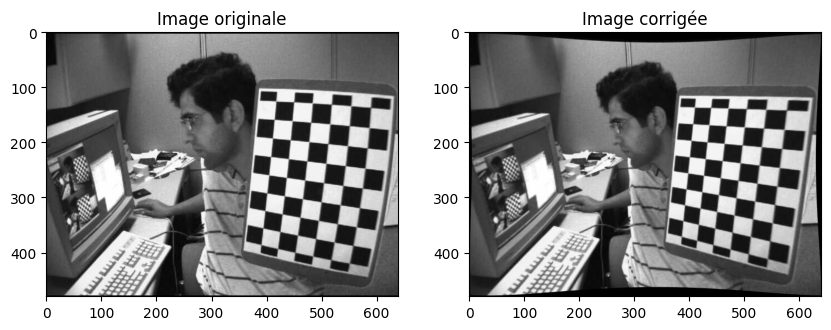

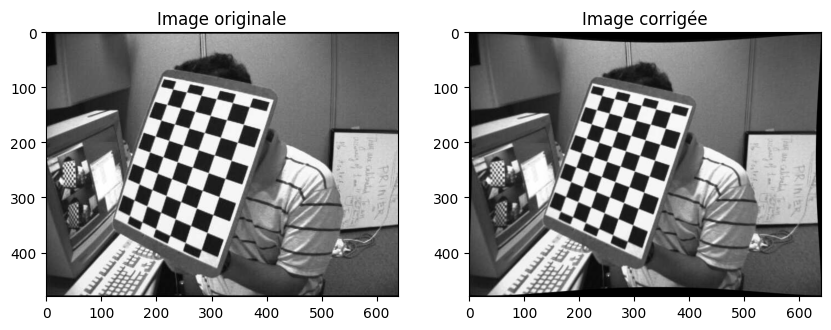

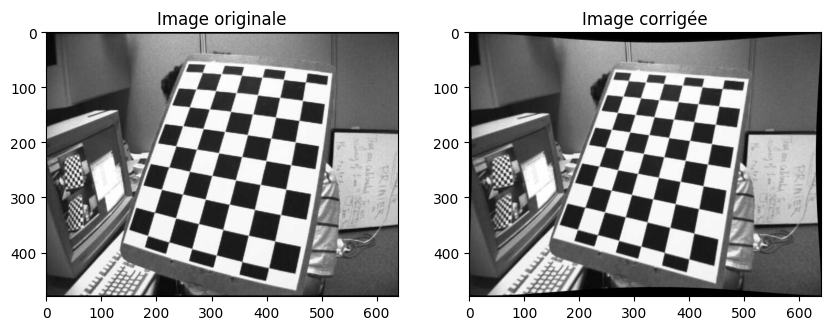

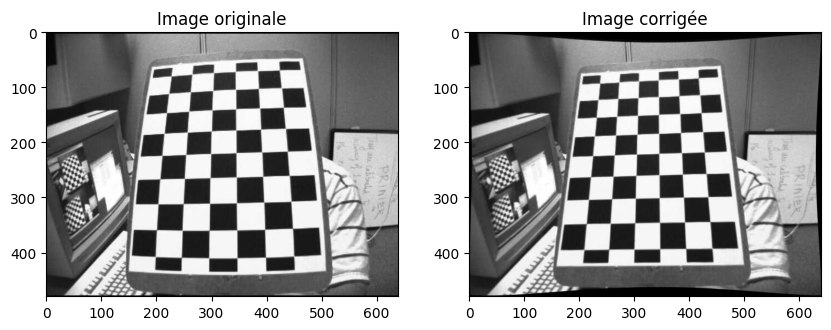

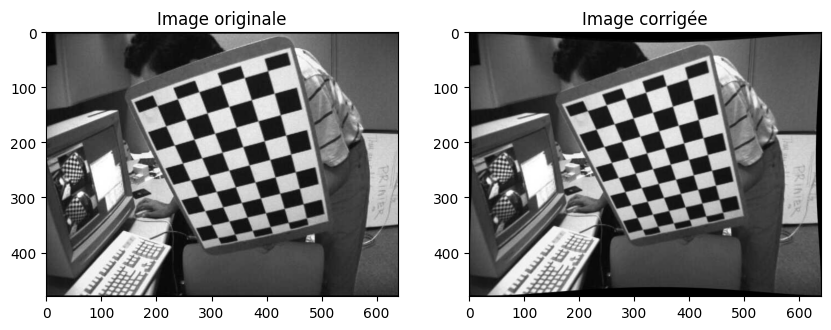

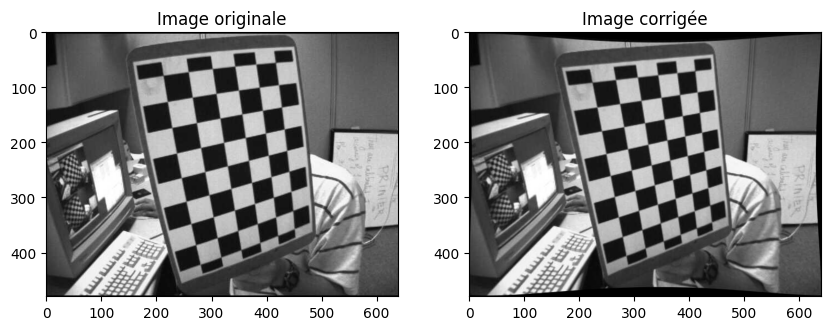

In [9]:
toggle("inline")

for i, img in enumerate(listimg):
    fig, ax = plt.subplots(1, 2, figsize=(10, 15))
    img_corrigee = cv.undistort(img, mtx, dist, None, newcameramtx)
    ax[0].imshow(img)
    ax[0].set_title('Image originale')
    ax[1].imshow(img_corrigee)
    ax[1].set_title('Image corrigée')
    plt.show()


## Q6

In [10]:
print("Matrice K = {}".format(mtx))
print("Centre de projection = {}".format(mtx[:2,2]))
print("Paramètres de distorsions (k1, k2, p1, p2, k3) = {}".format(dist))

Matrice K = [[534.11511147   0.         341.43669562]
 [  0.         534.34917347 232.07577468]
 [  0.           0.           1.        ]]
Centre de projection = [341.43669562 232.07577468]
Paramètres de distorsions (k1, k2, p1, p2, k3) = [[-0.29374636  0.09736158  0.          0.          0.10434623]]


On retrouve bien notre matrice K avec $f_x$, $f_y$, $u_0$, $v_0$, ainsi que $s$ le paramètre de cisaillement ici nul.

On retrouve aussi les coefficients de distorsion radiaux $k_1$, $k_2$, $k_3$, non nuls, ainsi que les coefficients de distorsion tangentiels $p_1$, $p_2$, qui eux sont nuls. D'après les équations présentées par la suite, cela veut dire que :

$$\begin{cases}
  x_{disttan} = x_{distrad} = x (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
  y_{disttan} = y_{distrad} = y (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
\end{cases}$$


---

Jsuis pas 100% sûr de la suite mais le sujet est un peu n'imp de toute façon, chaud que vous fassiez une issue github ou me dm si vous avez mieux réussi

---

## Q7

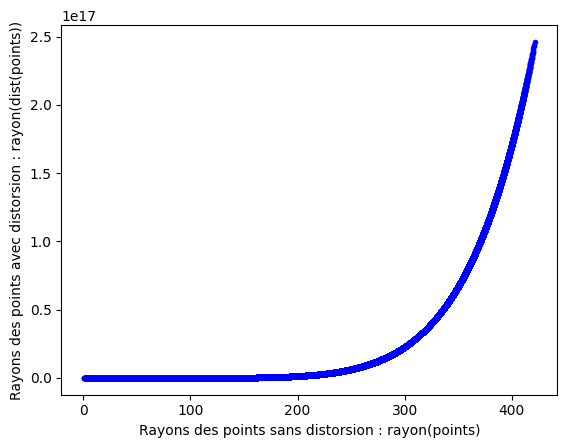

In [11]:
# Récupérer la taille de l'image
img = cv.imread('./ocv-pics/left01.jpg')
h,  w = img.shape[:2]

cx, cy = mtx[:2,2]
k1, k2, p1, p2, k3 = dist.flat

# meshgrid des coordonnées centrées sur le centre de l'image en faisant (-cx, -cy)
x, y = np.meshgrid(np.linspace(0, w-1, w) - cx, np.linspace(0, h-1, h) - cy)
points_sans_distorsion = np.stack((x, y), axis=-1)

rayons = np.sqrt((points_sans_distorsion[:, :, 0])**2 + (points_sans_distorsion[:, :, 1])**2)

# On applique la formule des distorsions radiales
points_avec_distorsion = np.zeros_like(points_sans_distorsion)
for i in range(2):
    points_avec_distorsion[:,:,i] = points_sans_distorsion[:,:,i] * (1 + k1 * rayons**2 + k2 * rayons**4 + k3 * rayons**6)

# fonctionne aussi sans boucle :
# points_avec_distorsion = points_sans_distorsion * np.stack([1 + k1 * rayons**2 + k2 * rayons**4 + k3 * rayons**6] * 2, axis=-1) 

# On compare le rayon (par rapport au centre de l'image) des points avant et après distorsion
rayons_no_dist = rayons.flatten()
rayons_dist = np.sqrt((points_avec_distorsion[:, :, 0])**2 + (points_avec_distorsion[:, :, 1])**2).flatten()

plt.xlabel('Rayons des points sans distorsion : rayon(points)')
plt.ylabel('Rayons des points avec distorsion : rayon(dist(points))')

plt.plot(rayons_no_dist, rayons_dist, 'b.')


On observe bien des distortions radiales de plus en plus fortes à mesure que l'on s'éloigne du centre de l'image.

## Q8

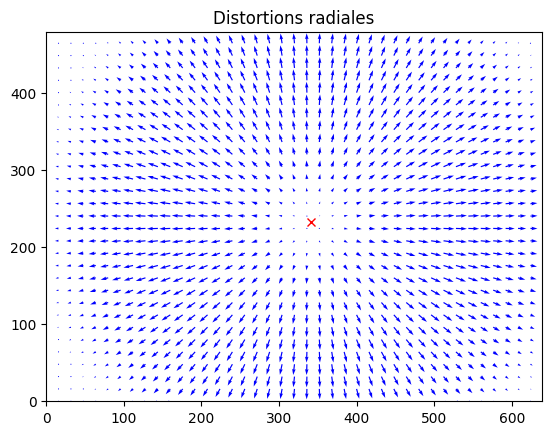

In [12]:
xx, yy = np.meshgrid(np.arange(img.shape[1])[::16], np.arange(img.shape[0])[::16])

mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (img.shape[1], img.shape[0]), cv.CV_32FC1)

mapx = mapx[::16, ::16]
mapy = mapy[::16, ::16]

vx = mapx - xx
vy = mapy - yy

plt.figure()
plt.xlim(0, w - 1)
plt.ylim(0, h - 1)

plt.plot(mtx[0, 2], mtx[1, 2], 'rx')
plt.quiver(xx.flatten(), yy.flatten(), vx.flatten(), vy.flatten(), color='b')
plt.title('Distortions radiales')
plt.show()

## Q9

In [13]:
mean_error = 0
imgpoints2 = []
for i in range(len(objpoints)):
    projpoints, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    imgpoints2.append(projpoints)
    error = cv.norm(imgpoints[i], projpoints, cv.NORM_L2)/len(projpoints)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

errors_2d = []
for i in range(len(imgpoints)):
    err_2d = np.sum((np.array(imgpoints[i]) - np.array(imgpoints2[i]))**2) # formule du cours
    # err_2d = cv.norm(imgpoints[i], imgpoints2[i], cv.NORM_L2)**2 # avec la fonction cv2.norm (meme resultat)
    errors_2d.append(err_2d)

mean_2d_error = np.mean(errors_2d)
print(f"Mean 2D reprojection error: {mean_2d_error} pixels")



total error: 0.02482698015587943
Mean 2D reprojection error: 1.1119483709335327 pixels


J'ai utilisé la formule du cours diapo 46 page 43:

$\epsilon_{2D}(P) = \underset{i}{\sum}(x_i - f(P, X_i))^2$

`imgpoints` sont les $x_i$ et `imgpoints2` sont les $f(P, X_i)$ car viennent de `cv.projectPoints`. (pas sur à 100% d'avoir utilisé la formule et les valeurs correctement).

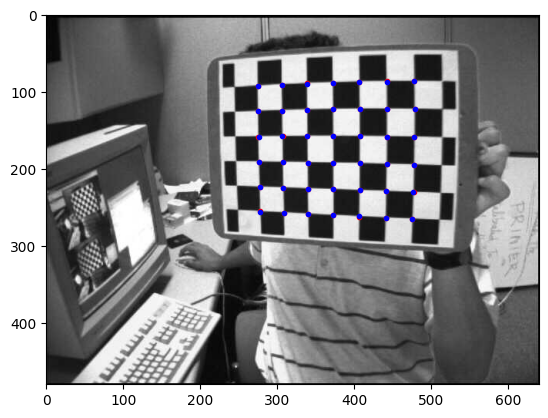

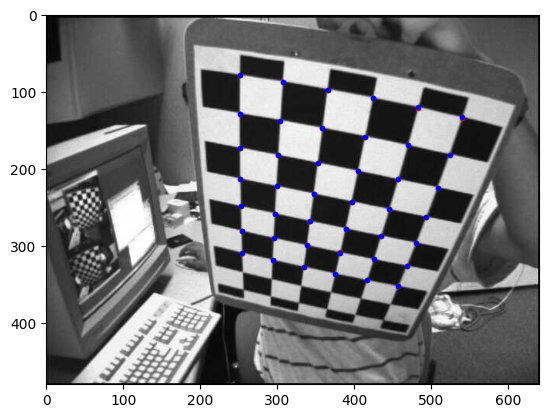

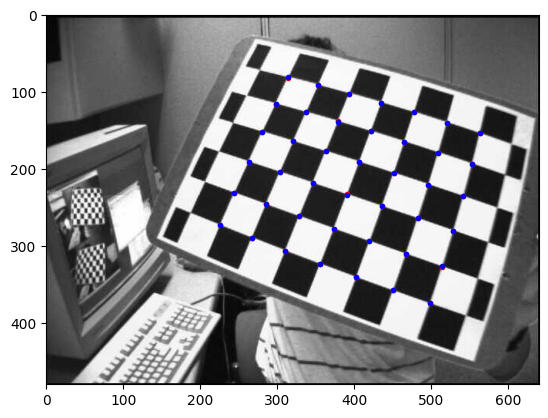

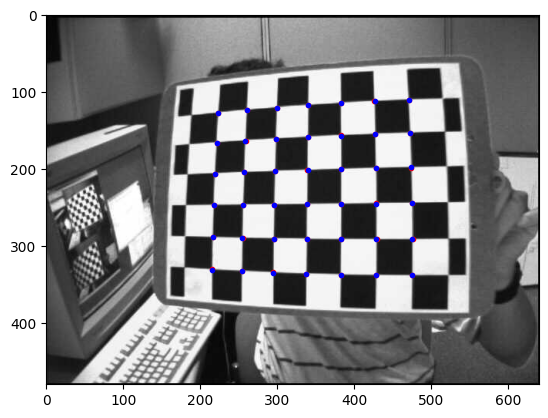

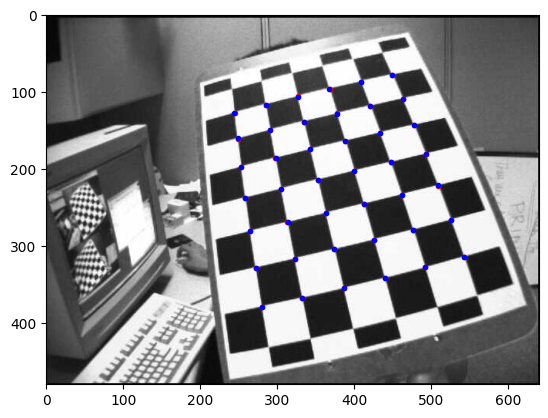

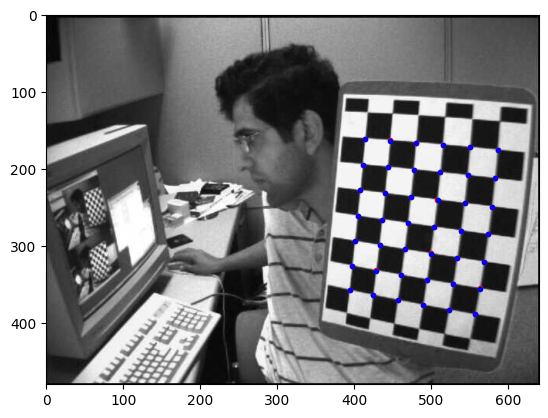

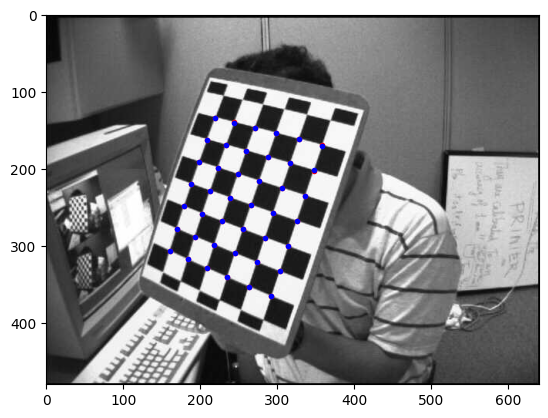

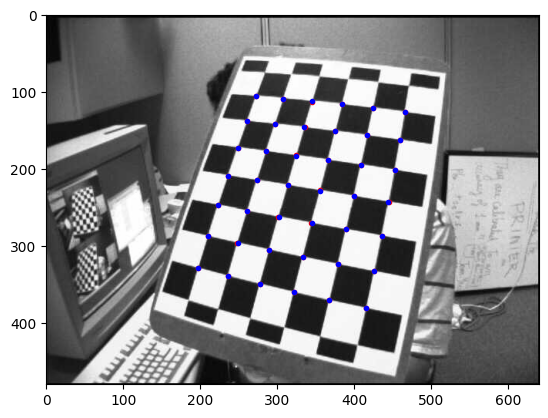

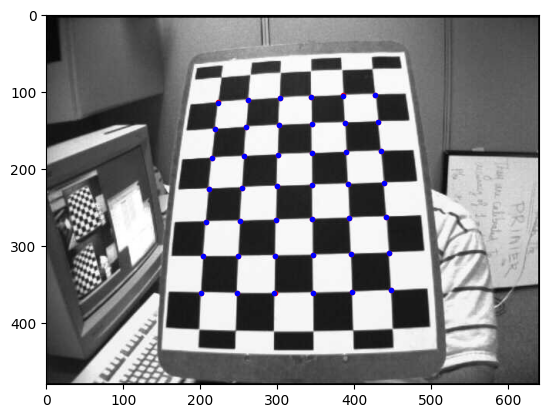

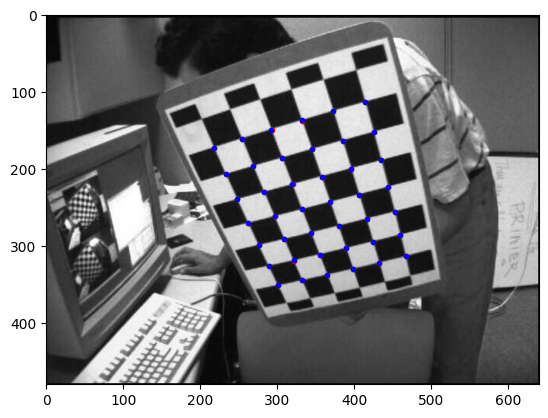

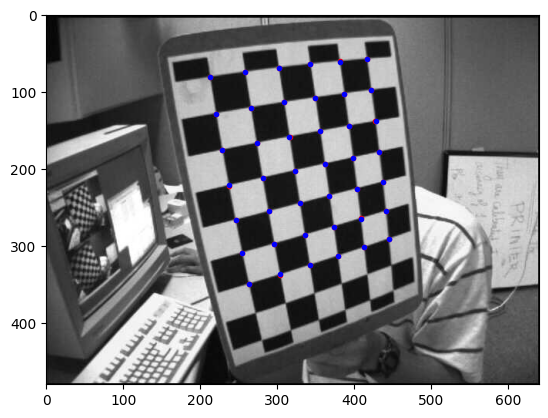

In [14]:
toggle("inline")

plt.figure()

# for img, pts, pts_ori in zip(listimg, imgpoints2, imgpoints):
#     for pt in range(pts.shape[0]):
#         img = cv.circle(img, (int(pts[pt,0,0]), int(pts[pt,0,1])), int(mean_2d_error), (255,0,0), 1)
#     plt.imshow(img)
#     plt.show()

# L'erreur est trop petite pour bien la voir en dessinant des cercles avec un rayon de mean_2d_error
# On dessine ici les points ainsi que les points projetés pour voir l'écart

for img, pts, pts2 in zip(listimg, imgpoints, imgpoints2):
    plt.imshow(img)
    plt.plot(pts[:,0,0], pts[:,0,1], 'r.')
    plt.plot(pts2[:,0,0], pts2[:,0,1], 'b.')
    plt.show()

On peut voir l'erreur au fait que les points projetés (bleus) ne sont pas alignés avec les points réels (rouges).

## Q11
Revenir au début, décommenter après "`Revenir ici pour question 11`" où on ne sélectionne que les images `01`, `04` et `07`, puis réexécuter tout le code.

Les images sont bien plus déformées après correction pour ce calibrage. L'erreur de reprojection (si elle a été correctement calculée Q9) ne semble pas beaucoup affectée par le fait de ne prendre que 3 images.

# Lien pour télécharger annale P23

In [ ]:
import binascii
hexa = b'4e616e206a652064c3a9636f6e6e65206a27616920706173205e5e220a626f6e20636f757261676520706f7572206c65732072c3a9766973696f6e732021'
lien_annale = binascii.unhexlify(hexa).decode('utf-8')
print(lien_annale)